# Plot data by category

Export pedigree data and tensile test results for composite materials, process the data in a `pandas` DataFrame, and plot summaries of the data (including layup information) using `matplotlib` and `seaborn`.

## Get data from Granta MI

Connect to Granta MI and specify a database.

In [1]:
from GRANTA_MIScriptingToolkit import granta as mi

session = mi.Session('localhost', autologon=True)
training_db = session.get_db('MI Training')
training_db.set_unit_system('Metric')

Specify the records and attributes you want to export from the first table. We want to use attributes describing the layup for all records in the *Composite Pedigree* table.

In [2]:
comp_pedigree = training_db.get_table('Composite Pedigree')
pedigree_records = comp_pedigree.all_records()
pedigree_attributes = ['Panel number', 'Ply count', 'Panel thickness, average (measured)',
                       'Ply thickness, average (measured)']
comp_pedigree.bulk_fetch(pedigree_records, attributes=pedigree_attributes)

Specify the records you want to export from the second table. Here, a link group is used to export only records linked to records in the first table.

Alternatively, you can specify a table with no link groups to the original table, as long as you can join the two datasets later on. For example, we could search for all records created after a certain date, or tested on a certain machine.

In [3]:
link_group = 'Tensile test data'

# Use a set comprehension to ensure we only select each record once
tensile_test_records = {tr for pr in pedigree_records for tr in pr.links[link_group]}
tensile_test_records = list(tensile_test_records)

Specify the attributes you want to export from the second table. *Panel number* will be used to relate the tensile tests to the layup data.

In [4]:
tensile_test_data = training_db.get_table('Tensile Test Data')
tensile_attributes = ['Panel number', 'Specimen ID', "Young's Modulus (11-axis)", 'Ultimate Tensile Strength',
                      'Test Type']
tensile_test_data.bulk_fetch(tensile_test_records, attributes=tensile_attributes)

## Use DataFrames to pre-process and append the data

### Build a separate DataFrame for each table

Create a DataFrame for each Granta MI table. The DataFrames are built from two separate lists of dictionaries:

In [5]:
import pandas as pd
from functools import partial

def get_attr_vals(attributes, r):
    return {mi_attr: r.attributes[mi_attr].value for mi_attr in attributes}

get_pedigree_vals = partial(get_attr_vals, pedigree_attributes)
get_tensile_vals = partial(get_attr_vals, tensile_attributes)

pedigree_data = [get_pedigree_vals(r) for r in pedigree_records]
tensile_data = [get_tensile_vals(r) for r in tensile_test_records]

Create a DataFrame `pedigree_df` that contains the pedigree records. Set the DataFrame index to be the *Panel number*
attribute value.

In [6]:
pedigree_df = pd.DataFrame(pedigree_data).set_index('Panel number')
pedigree_df.head()

Ply count                Panel thickness, average (measured)  \
Panel number                                                                 
LBJ13                 6  <PointValue name: Panel thickness, average (me...   
LBJ14                 6  <PointValue name: Panel thickness, average (me...   
LBJ42                 6  <PointValue name: Panel thickness, average (me...   
LBJ53                 6  <PointValue name: Panel thickness, average (me...   
LBJ62                 6  <PointValue name: Panel thickness, average (me...   

                              Ply thickness, average (measured)  
Panel number                                                     
LBJ13         <PointValue name: Ply thickness, average (meas...  
LBJ14         <PointValue name: Ply thickness, average (meas...  
LBJ42         <PointValue name: Ply thickness, average (meas...  
LBJ53         <PointValue name: Ply thickness, average (meas...  
LBJ62         <PointValue name: Ply thickness, average (meas...

Create a second DataFrame `tensile_df` that contains the tensile test results. Again, set the index to be the *Panel
number* attribute value.

In [7]:
tensile_df = pd.DataFrame(tensile_data).set_index('Panel number')
tensile_df.head()

Specimen ID                          Young's Modulus (11-axis)  \
Panel number                                                                  
LBJ62           LBJ6213A  <PointValue name: Young's Modulus (11-axis), v...   
LBJ62           LBJ6219A  <PointValue name: Young's Modulus (11-axis), v...   
LBJ14           LBJ1415A  <PointValue name: Young's Modulus (11-axis), v...   
LBJ13           LBJ1311A  <PointValue name: Young's Modulus (11-axis), v...   
LBJ42           LBJ4211A  <PointValue name: Young's Modulus (11-axis), v...   

                                      Ultimate Tensile Strength     Test Type  
Panel number                                                                   
LBJ62         <PointValue name: Ultimate Tensile Strength, v...  [0° tension]  
LBJ62         <PointValue name: Ultimate Tensile Strength, v...  [0° tension]  
LBJ14         <PointValue name: Ultimate Tensile Strength, v...  [0° tension]  
LBJ13         <PointValue name: Ultimate Tensile Strength, v...  [0° tension]  
LBJ42         <PointValue name: Ultimate Tensile Strength, v...  [0° tension]

### Join the dataframes

Use the `dataframe.join()` method to create a DataFrame with both sets of data. The join type will default to a left-join if not specified; this is fine in our case because the records were linked via a smart link in Granta MI, and so the set of indices is the same for both DataFrames.

In [8]:
df = pedigree_df.join(tensile_df)
df.head()

Ply count                Panel thickness, average (measured)  \
Panel number                                                                 
LBJ13                 6  <PointValue name: Panel thickness, average (me...   
LBJ13                 6  <PointValue name: Panel thickness, average (me...   
LBJ13                 6  <PointValue name: Panel thickness, average (me...   
LBJ14                 6  <PointValue name: Panel thickness, average (me...   
LBJ14                 6  <PointValue name: Panel thickness, average (me...   

                              Ply thickness, average (measured) Specimen ID  \
Panel number                                                                  
LBJ13         <PointValue name: Ply thickness, average (meas...    LBJ1311A   
LBJ13         <PointValue name: Ply thickness, average (meas...    LBJ1312A   
LBJ13         <PointValue name: Ply thickness, average (meas...    LBJ1313A   
LBJ14         <PointValue name: Ply thickness, average (meas...    LBJ1415A   
LBJ14         <PointValue name: Ply thickness, average (meas...    LBJ1417A   

                                      Young's Modulus (11-axis)  \
Panel number                                                      
LBJ13         <PointValue name: Young's Modulus (11-axis), v...   
LBJ13         <PointValue name: Young's Modulus (11-axis), v...   
LBJ13         <PointValue name: Young's Modulus (11-axis), v...   
LBJ14         <PointValue name: Young's Modulus (11-axis), v...   
LBJ14         <PointValue name: Young's Modulus (11-axis), v...   

                                      Ultimate Tensile Strength     Test Type  
Panel number                                                                   
LBJ13         <PointValue name: Ultimate Tensile Strength, v...  [0° tension]  
LBJ13         <PointValue name: Ultimate Tensile Strength, v...  [0° tension]  
LBJ13         <PointValue name: Ultimate Tensile Strength, v...  [0° tension]  
LBJ14         <PointValue name: Ultimate Tensile Strength, v...  [0° tension]  
LBJ14         <PointValue name: Ultimate Tensile Strength, v...  [0° tension]

### Refine the data

Extract simple numeric and string values from MI Scripting Toolkit data types.

In [9]:
point_cols = ['Panel thickness, average (measured)',
              'Ply thickness, average (measured)',
              'Ultimate Tensile Strength',
              "Young's Modulus (11-axis)"]
df_processed = df[point_cols].applymap(lambda x: x.points[0] if not x.is_empty() else None)
df_processed['Test Type'] = df['Test Type'].map(lambda x: x[0])
df_processed[['Ply count', 'Specimen ID']] = df[['Ply count', 'Specimen ID']]
df_processed.head()

Panel thickness, average (measured)  \
Panel number                                        
LBJ13                                    1.397000   
LBJ13                                    1.397000   
LBJ13                                    1.397000   
LBJ14                                    1.431636   
LBJ14                                    1.431636   

              Ply thickness, average (measured)  Ultimate Tensile Strength  \
Panel number                                                                 
LBJ13                                  0.232029                1582.870937   
LBJ13                                  0.232029                1542.122918   
LBJ13                                  0.232029                1612.952766   
LBJ14                                  0.238044                1611.201497   
LBJ14                                  0.238044                1639.559637   

              Young's Modulus (11-axis)   Test Type  Ply count Specimen ID  
Panel number                                                                
LBJ13                         47.594514  0° tension          6    LBJ1311A  
LBJ13                         47.353197  0° tension          6    LBJ1312A  
LBJ13                         47.387671  0° tension          6    LBJ1313A  
LBJ14                               NaN  0° tension          6    LBJ1415A  
LBJ14                               NaN  0° tension          6    LBJ1417A

Finally, create a `units` dict so you can create plots with meaningful axis labels.

In [10]:
attr_defs = [comp_pedigree.attributes[attr] for attr in pedigree_attributes] + \
            [tensile_test_data.attributes[attr] for attr in tensile_attributes]
units = {attr.name: attr.unit for attr in attr_defs if attr.unit}
units

{'Panel thickness, average (measured)': 'mm',
 'Ply thickness, average (measured)': 'mm',
 "Young's Modulus (11-axis)": 'GPa',
 'Ultimate Tensile Strength': 'MPa'}

## Plot the data

This code snippet is optional, and is included to increase the size of all plots generated in this
notebook.

In [11]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 125

### Investigate the relationship between two properties

Create a scatter plot with `matplotlib` comparing *Ultimate Tensile Strength* of the panels to *Ply thickness, average*.

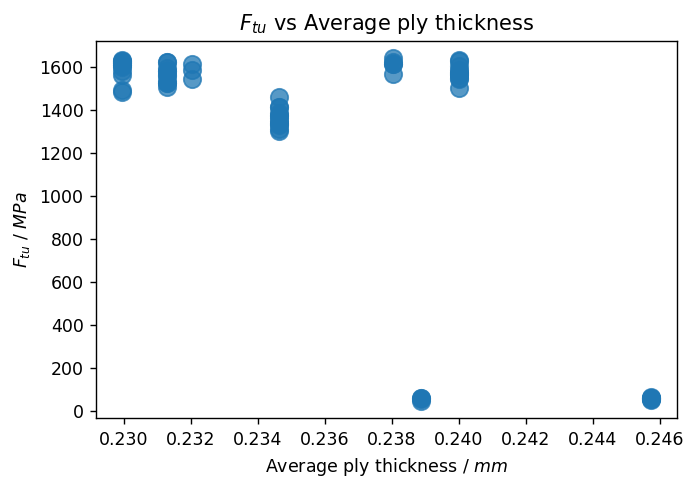

In [12]:
import matplotlib.pyplot as plt

ply_thickness_unit = units['Ply thickness, average (measured)']
ftu_unit = units["Ultimate Tensile Strength"]
ply_thickness_label = rf'Average ply thickness / ${ply_thickness_unit}$'
ftu_label = rf'$F_{{tu}}$ / ${ftu_unit}$'

fig, ax = plt.subplots()
ax.scatter(data=df_processed, x="Ply thickness, average (measured)", y="Ultimate Tensile Strength", alpha=0.75, s=100)
ax.set_xlabel(ply_thickness_label)
ax.set_ylabel(ftu_label)
_ = ax.set_title(r'$F_{tu}$ vs Average ply thickness')

There is a significant difference between the results at 1200 - 1600 MPa and the group below 100 MPa. We need to identify what causes this difference, and then represent the data in a clearer way.

### Investigate the impact of other properties

First, examine the underlying data; use the `DataFrame.describe()` method to view a statistical summary of the data in each column.

In [13]:
df_processed.describe(include='all')

Panel thickness, average (measured)  \
count                             67.000000   
unique                                  NaN   
top                                     NaN   
freq                                    NaN   
mean                               1.534167   
std                                0.294450   
min                                1.379415   
25%                                1.385455   
50%                                1.410677   
75%                                1.438564   
max                                2.213429   

        Ply thickness, average (measured)  Ultimate Tensile Strength  \
count                           67.000000                  67.000000   
unique                                NaN                        NaN   
top                                   NaN                        NaN   
freq                                  NaN                        NaN   
mean                             0.235604                1288.110261   
std                              0.005039                 557.743977   
min                              0.229948                  44.629768   
25%                              0.231279                1353.613343   
50%                              0.234618                1545.653034   
75%                              0.240007                1603.610369   
max                              0.245727                1639.559637   

        Young's Modulus (11-axis)   Test Type  Ply count Specimen ID  
count                   18.000000          67  67.000000          67  
unique                        NaN           2        NaN          67  
top                           NaN  0° tension        NaN    LBJ8314A  
freq                          NaN          56        NaN           1  
mean                    42.775844         NaN   6.492537         NaN  
std                     13.523385         NaN   1.119701         NaN  
min                     13.217251         NaN   6.000000         NaN  
25%                     47.022249         NaN   6.000000         NaN  
50%                     47.973725         NaN   6.000000         NaN  
75%                     49.364743         NaN   6.000000         NaN  
max                     51.400420         NaN   9.000000         NaN

The *Test Type* column summary shows that the most frequent value is '0° tension' (as expected), but there are 9 occurrences of a second test type.

To identify all possible values in the *Test Type* column, use `DataFrame['Test Type'].unique()`.

In [14]:
df_processed['Test Type'].unique()

array(['0° tension', '90° tension'], dtype=object)

Although there is only one populated attribute for *Ultimate Tensile Strength* and *Young's modulus*, the *Test Type* column shows that the tensile tests were performed in two different directions. 

Since composite materials are often highly orthotropic, the direction of the test must be taken into account when plotting the results. We can filter the DataFrame based on the *Test Type* column when plotting:

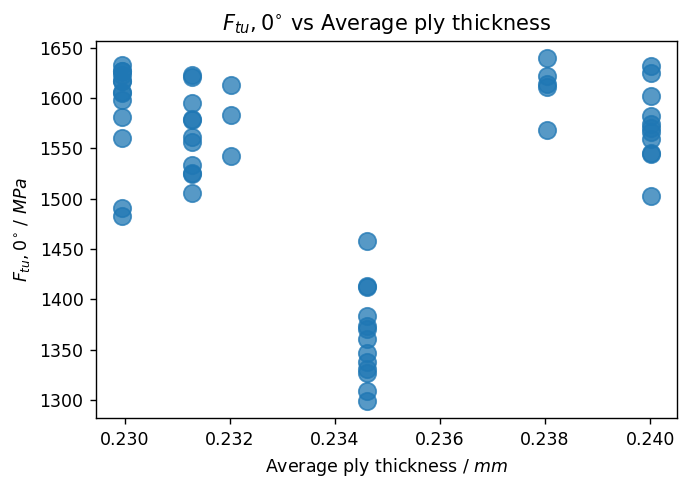

In [15]:
ftu_0_label = rf'$F_{{tu}}, 0^{{\circ}}$ / ${ftu_unit}$'
df_0_tension = df_processed[df_processed['Test Type'] == '0° tension']

fig, ax = plt.subplots()
ax.scatter(data=df_0_tension,
           x="Ply thickness, average (measured)",
           y="Ultimate Tensile Strength",
           alpha=0.75,
           s=100)
ax.set_xlabel(ply_thickness_label)
ax.set_ylabel(ftu_0_label)
_ = ax.set_title(r'$F_{tu}, 0^{{\circ}}$ vs Average ply thickness')

We can also overlay the 90° *Ultimate Tensile Strength* results, using `.twinx()` to plot them on a separate y-axis.

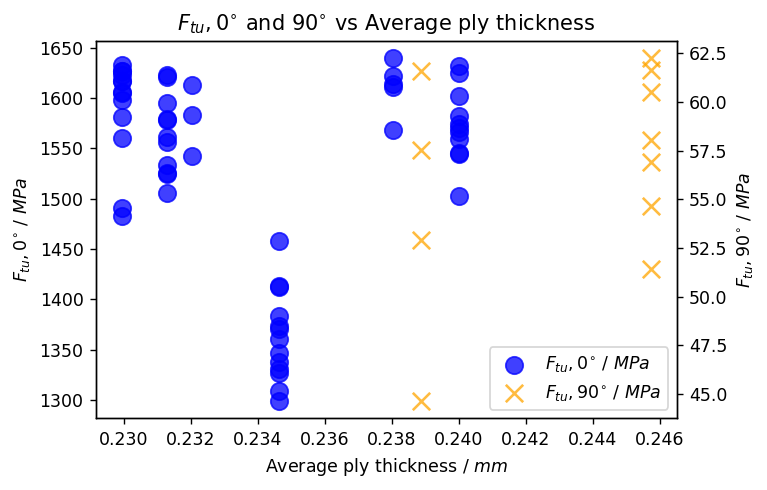

In [16]:
ftu_90_label = rf'$F_{{tu}}, 90^{{\circ}}$ / ${ftu_unit}$'
df_90_tension = df_processed[df_processed['Test Type'] == '90° tension']

fig, ax1 = plt.subplots()
ax1.scatter(data=df_0_tension,
            x="Ply thickness, average (measured)",
            y="Ultimate Tensile Strength",
            color="blue",
            marker="o",
            alpha=0.75,
            s=100)
ax2 = plt.twinx()
ax2.scatter(data=df_90_tension,
            x="Ply thickness, average (measured)",
            y="Ultimate Tensile Strength",
            color="orange",
            marker="x",
            alpha=0.75,
            s=100)

ax1.set_xlabel(ply_thickness_label)
ax1.set_ylabel(ftu_0_label)
ax2.set_ylabel(ftu_90_label)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

ax1.legend(h1+h2, [ftu_0_label, ftu_90_label], loc='lower right')
_ = ax1.set_title(r'$F_{tu}, 0^{{\circ}}$ and $90^{{\circ}}$ vs Average ply thickness')